In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 

In [16]:
csvs = Path("../results/like_rar_experiment/03/").rglob("*.csv")

dfs = [] 
for csv in csvs:
    df = pd.read_csv(csv)
    df['loss_path'] = list(csv.parent.glob("rar_loss*.npz"))[0]
    dfs.append(df)

df = pd.concat(dfs)

print("before deduplication", len(df))
df = df.drop_duplicates(subset = [
                         'method',
                         'hard_constrained',
                         'distribution',
                         'n_iterations',
                         'i', 
                         'seed'
                        ],
                        keep='last')
print("after deduplication", len(df))

before deduplication 3030
after deduplication 3030


In [10]:
#df = df.loc[df['seed'] < 4]

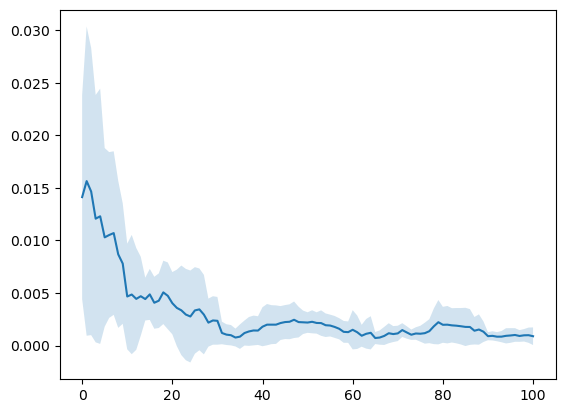

In [12]:
means = df.loc[
    (df["method"] == "RAR") & (df["hard_constrained"] == True) & (df['distribution'] == False),
].groupby(['i'])['mse'].mean()

stds = df.loc[
    (df["method"] == "RAR") & (df["hard_constrained"] == True) & (df['distribution'] == False),
].groupby(['i'])['mse'].std()

plt.plot(means)
plt.fill_between(means.index, means - stds, means + stds, alpha=0.2)


In [13]:
def loc(
        df,
        method,
        distribution,
        n_iterations
):
    return df.loc[
            (df["method"] == method) &
            (df['distribution'] == distribution) &
            (df["n_iterations"] == n_iterations),
        ]

def get_groupby_metric(
        df,
        f = 'mean'
):
    return df.groupby('i')['mse'].agg(f)


def load_losses(
        filepath
):
    with np.load(filepath) as data:
        return data['loss_train'], data['loss_test']
    
def get_loss_distribution(
        cur_df
):
        losses_train = []
        losses_test = [] 

        loss_files = cur_df['loss_path'].unique()
        for loss_file in loss_files:
                loss_train, loss_test = load_losses(loss_file)
                
                losses_train.append(loss_train)
                losses_test.append(loss_test)

        losses_train = np.hstack(losses_train)
        losses_test = np.hstack(losses_test)

        mean_train = np.mean(losses_train, axis=1)
        mean_test = np.mean(losses_test, axis=1)

        std_train = np.std(losses_train, axis=1)
        std_test = np.std(losses_test, axis=1)
                
        return (mean_train, std_train), (mean_test, std_test)

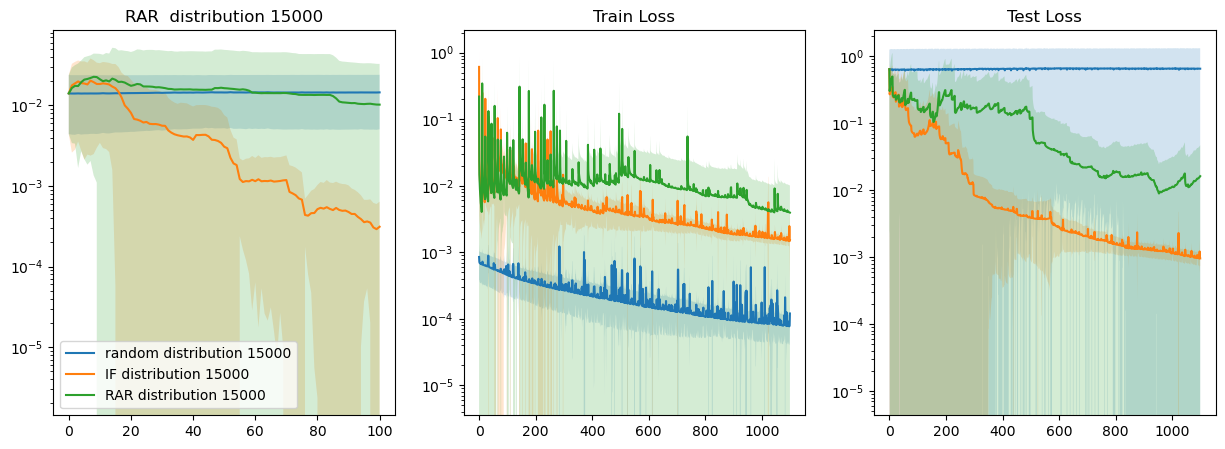

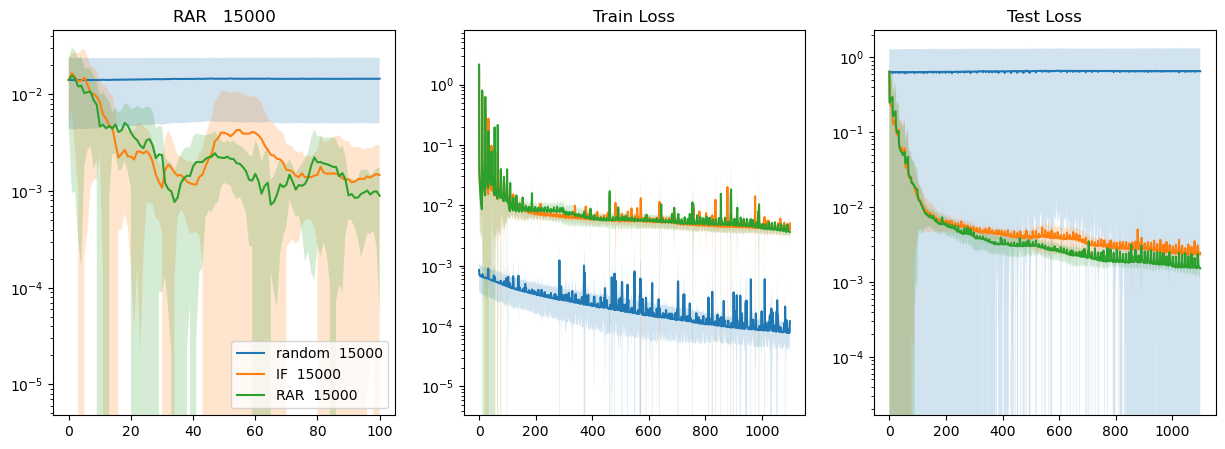

In [14]:
hard_constrained = False
for distribution in [True, False]:
    for n_iterations in [15000]:
        fig, ax = plt.subplots(
            ncols = 3, figsize=(15, 5)
        )
        for method in ['random', 'IF', 'RAR']:

            cur_df = loc(df, method, distribution, n_iterations)
            means = get_groupby_metric(cur_df, 'mean')
            stds = get_groupby_metric(cur_df, 'std')
            
            (mean_train, std_train), (mean_test, std_test) = get_loss_distribution(cur_df)
            x = np.arange(0, len(mean_train))



            ax[0].plot(means.index, means, label=f"{method} {'distribution' if distribution else ''} {n_iterations}")
            ax[0].fill_between(means.index, means - stds, means + stds, alpha=0.2)
            ax[0].set_title(f"{method}  {'distribution' if distribution else ''} {n_iterations}")             
            ax[0].set_yscale('log')  

            ax[1].plot(x, mean_train)
            ax[1].fill_between(x, mean_train - std_train, mean_train + std_train, alpha=0.2)
            ax[1].set_title("Train Loss")
            ax[1].set_yscale('log')

            ax[2].plot(x, mean_test, label=method)
            ax[2].fill_between(x, mean_test - std_test, mean_test + std_test, alpha=0.2)
            ax[2].set_title("Test Loss")
            ax[2].set_yscale('log')

        ax[0].legend()


        plt.show()